# DeepVaR: Value-at-Risk prediction leveraging Deep Learning


### Introduction

* Value at Risk (VAR) is a rather simple yet valuable risk estimation measure, which helps traders and investors understand the risk of loss for their investments. Using VaR financial professionals can estimate how much their investments could lose in a specified time window (e.g., during a day or month) under normal market conditions. 

* VaR can be calculated at different levels and granularities. For example, it can used to estimate the risk of a single asset or of a portfolio of assets. This is a very common use of VaR by commercial banks and investment organizations, which wish to estimate and understand the potential losses of their institutional portfolios. 

* From a statistical perspective VaR quantifies the maximum potential losses over a specified timeframe with a degree of confidence. Confidence is therefore an important parameter of VaR calculation. For example, if for a given portfolio the 95% confidence of a one-day VAR is 100.000 EUR, this means that there is a 95% confidence that the portfolio will not lose more than 100.000 EUR within a day. 95% and 99% are the most common confidence internals used in VaR calculation.

$$P[r < VaR_a] = a $$ where r, a are the portfolio returns and the confidence probability respectively.
 
* Since the introduction of VaR as a standard risk metric, various types of models have been developed for its assessment. The main categories of which are the:
    * Parametric: Portfolio returns and their distribution should be theoretically defined prior to VaR estimation. Some well-known methods of the parametric category are the Variance-Covariance Method (VC) and many GARCH-variants Methods, such as the Risk Metrics model.
    * Non-Parametric: Assumptions regarding the distribution of returns are not required. The Historical Simulation (HS) is the main representative of this method, where the empirical distribution of past portfolio returns is used to calculate VaR. 
    * Semi-Parametric: Some assumptions regarding the distribution of returns are made. The Monte Carlo Method is the main semi-parametric method which generates random scenarios for future portfolio returns, drawing their distribution based on some non-linear pricing models.
    
DeeVaR is a semi-parametric approach combining a deep neural network with Monte Carlo simulation. The DNN is used to estimate the parameters of the portfolio returns' distribution, which are used to produce the MC samples. As far as the DNN is concerned, the DeepAR estimator from GluonTS package is utilized in order to perform probabilistic forecasts, while the VaR is calculated leveraging DeepAR's output.

### The Data

In this example, the four FX instruments (AUDUSD, GBPUSD, USDJPY, EURUSD) with the highest liquidity among the rest have been chosen. The dataset consists of daily close prices, ranging from 2007-01-01 to 2020-12-18, with the data being obtained from https://eatradingacademy.com/software/forex-historical-data/. 

In [1]:
# import required libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# paths to data 
# downloaded from https://eatradingacademy.com/software/forex-historical-data/
paths = ["data/AUDUSD1440.csv",
         "data/GBPUSD1440.csv",
         "data/USDJPY1440.csv",
         "data/EURUSD1440.csv"]

In [4]:
def read_asset_data(path):
    
    ''' function to read a csv file
    with colums:[Time,Open,High,Low,Close,Volume]
    returning a pandas dataframe with index the "Time" and 
    column the "Close" price of the given asset'''
    
    # read csv
    asset = pd.read_csv(path, delimiter='\t', usecols=[0,4],names=['datetime','price'])
    asset.datetime = pd.to_datetime(asset.datetime)
    # set datetime as index
    asset.set_index('datetime', inplace=True)
    asset_name = "".join(re.findall("[a-zA-Z]+", path))[-9:-3]
    asset.rename(columns={"price": asset_name}, inplace=True)
    
    return asset[[asset_name]]

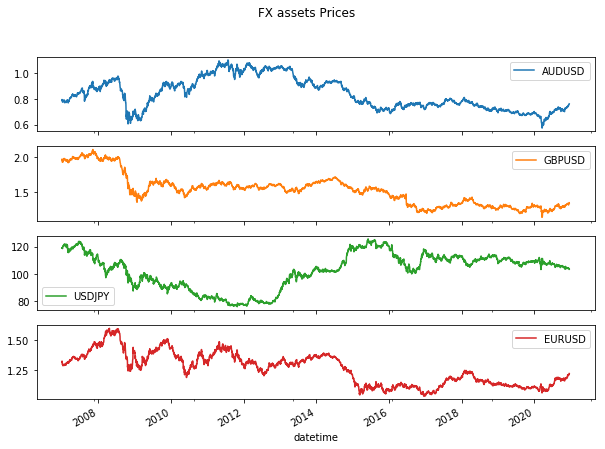

In [5]:
h = {}
# read all data
for i in range(len(paths)):
    h["asset" + str(i)] = read_asset_data(paths[i])
    
# Concat FX prices to one dataframe
prices = pd.concat(h, axis=1)
prices.columns = prices.columns.droplevel()
#prices.fillna(method='pad', axis=0, limit=2,inplace=True)
prices = prices.dropna()
#plot
prices.plot(subplots=True, title='FX assets Prices',figsize=(10, 7))
plt.show()

In [6]:
prices.tail()

,AUDUSD,GBPUSD,USDJPY,EURUSD
datetime,,,,
2020-12-14,0.75346,1.33249,104.008,1.21486
2020-12-15,0.75572,1.34465,103.647,1.21543
2020-12-16,0.75692,1.35019,103.475,1.21961
2020-12-17,0.76139,1.35681,103.148,1.22614
2020-12-18,0.76193,1.35142,103.281,1.22559


In [7]:
# asset returns calculation
returns = prices.pct_change().dropna()
# deepar model requires datetime index with constant frequency as input
returns = returns.asfreq(freq='1D', fill_value=0.0)
# we use the last 6 years of the data
returns = returns[returns.index>='2015-01-01']

In [8]:
returns.tail()

,AUDUSD,GBPUSD,USDJPY,EURUSD
datetime,,,,
2020-12-14,-0.001960,0.000691,0.000423,0.001277
2020-12-15,0.002999,0.009126,-0.003471,0.000469
2020-12-16,0.001588,0.004120,-0.001659,0.003439
2020-12-17,0.005906,0.004903,-0.003160,0.005354
2020-12-18,0.000709,-0.003973,0.001289,-0.000449


### The DeepAR model

DeepAR algorithm, which utilizes RNNs to produce probabilistic forecasts in the form of Monte Carlo samples that can be used to compute consistent quantile estimates in a certain prediction horizon. Moreover, this algorithm can be fed with several similar time series simultaneously, enabling cross-learning between them. Those features make DeepAR an ideal candidate model to predict VaR of FX portfolios, where the individual time series share similar dependencies and the overall goal is to draw the portfolio’s returns distribution.

DeepAR architecture, as summarized in bellow figure,  models the conditional distribution $P(z_i,t_{0:T}|z_i,1:t_{0-1})$ of the time series $z_i$ for future time-step from $t_0$ to $T$ given the past values of the $z_i$ from time-step 1 to $t_{0-1}$. It is assumed that the model distribution $Q(z_i;t_{0:T} |z_i;1:t_{0-1})$ consists of a product of likelihood factors. Several samples can be easily generated from the estimated returns distribution, in a MC fashion. Then VaR can be easily obtained from $VaR_a=q_{1-a}$.

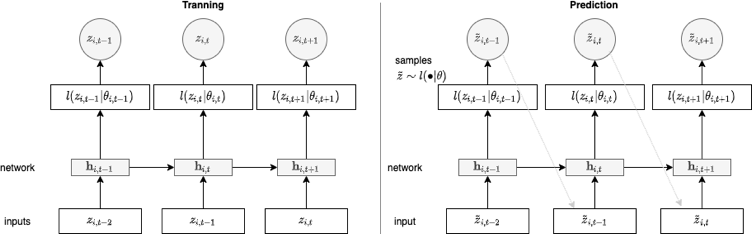



In [9]:
class DeepARModel:
    
    '''Class to ease fitting and predicting with GluonTS DeepAR estimator '''
    
    def __init__(self, freq='1D', context_length=15, prediction_length=10,
                 epochs=5, learning_rate=1e-4, n_layers=2., dropout=0.1):

        self.freq = freq
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_layers = n_layers
        self.dropout = dropout

    def df_to_np(self, ts):
        return ts.to_numpy().T

    def list_dataset(self, ts, train=True):
        
        '''expects as input a pandas df with datetime index and 
        columns the asset returns and outputs the train or test dataset in 
        a proper form to be used as intput to a GluonTS estimator'''
        
        custom_dataset = self.df_to_np(ts)
        start = pd.Timestamp(ts.index[0], freq=self.freq)
        if train == True:
            ds = ListDataset([{'target': x, 'start': start}
                              for x in custom_dataset[:, :-self.prediction_length]],
                             freq=self.freq)
        else:
            ds = ListDataset([{'target': x, 'start': start}
                              for x in custom_dataset],
                             freq=self.freq)
        return ds

    def fit(self, ts):
        
        '''expects as input a pandas df with datetime index and 
        columns the returns of the assets to be predicted'''
        # iniallize deepar estimator
        estimator = deepar.DeepAREstimator(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            freq=self.freq,
            trainer=Trainer(epochs=self.epochs,
                            ctx="cpu",
                            learning_rate=self.learning_rate,
                            num_batches_per_epoch=50,
                            ),
            num_layers=self.n_layers,
            dropout_rate=self.dropout,
            cell_type='lstm',
            num_cells=50
        )
        # prepare training data
        list_ds = self.list_dataset(ts, train=True)
        # train deepar on training data
        predictor = estimator.train(list_ds)
        return predictor

    def predict(self, ts ):
        '''expects as input a pandas df with datetime index and 
        columns the returns of the assets to be predicted'''
        # get the test data in proper form
        test_ds = self.list_dataset(ts, train=False)
        return self.estimator.predict(test_ds, num_samples=1000)


   

def make_forecasts(predictor, test_data, n_sampl):
    """takes a  predictor, gluonTS test data and the number of samples
    and returns MC samples for each datetime of the test set"""
    forecasts = []
    tss = []
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,
        predictor=predictor,
        num_samples=n_sampl
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    return forecasts, tss

def plot_prob_forecasts(ts_entry, forecast_entry, asset_name, plot_length=20):
    prediction_intervals = (99.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.title(f'Forecast of {asset_name} series Returns')
    plt.show()

#### Model training

In this exapmple the DeepAR estimator is trained on asset returns from 2015-01-01 to 2020-12-08 and is tested on a single 10-days ahead foracast. It is noted that the 4 time series are fed simutanesly for training and testing. 

The selected parameters of the DeepAR model are the following:
* frequency: 1 day
* prediction length: 10
* context length: 15
* epochs: 5
* learning rate: 1e-4
* dropout: 0.1

In [10]:
# train the DeepAR estimator
estimator = DeepARModel(prediction_length=10, context_length=15, epochs=5).fit(returns)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:03<00:00, 15.13it/s, epoch=5/5, avg_epoch_loss=-4.09]


#### Probabilistic Forecast

The `make_forecasts` function takes as input the trained DeepAR estimator, the test data and the number of samples to be generated.  The output of the forecast on the test data is a matrix with dimensions [N_assets x Samples x Prediction Length] i.e. [4x1000x10], which is used to generate the following plots. 



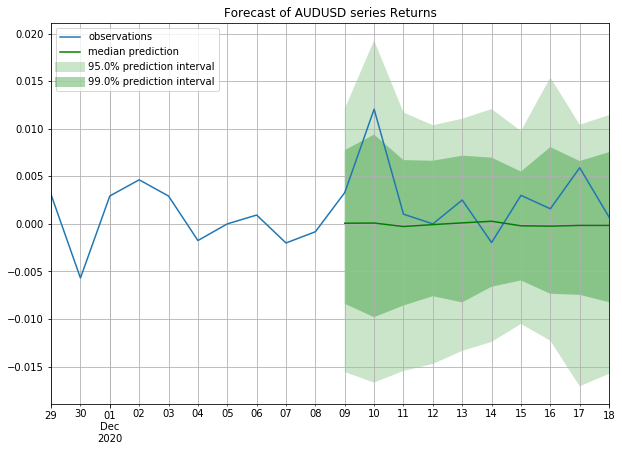

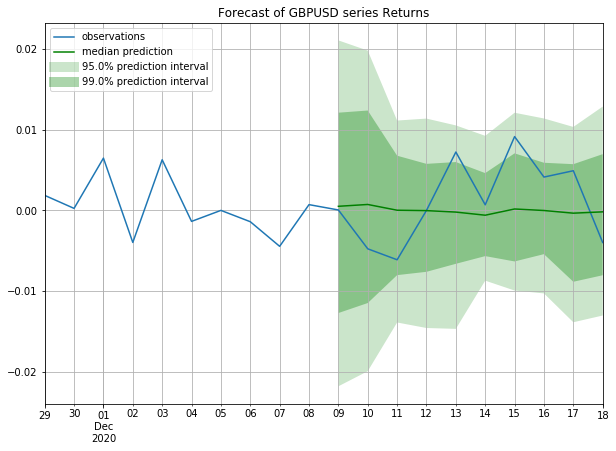

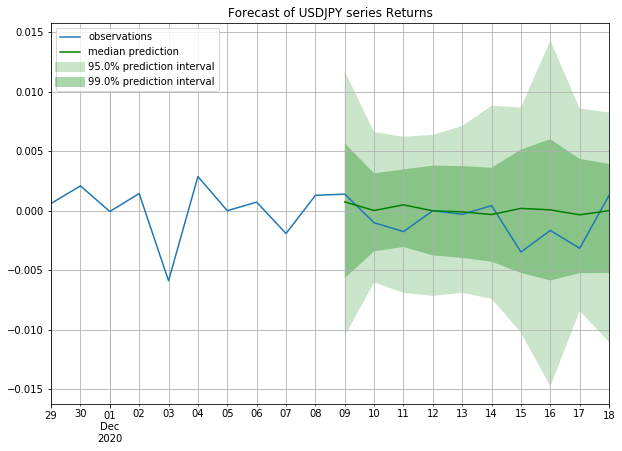

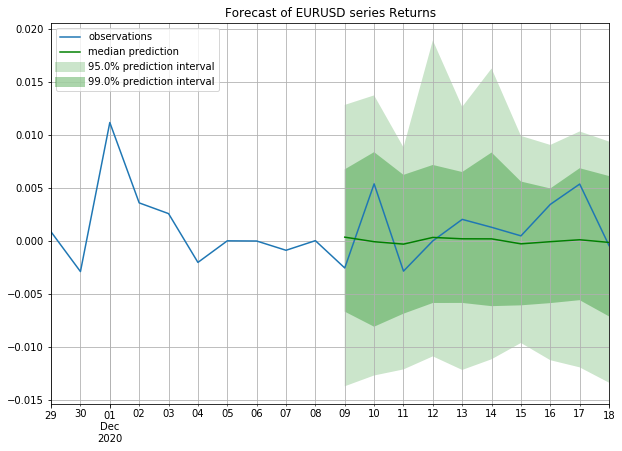

In [11]:
# get the test data
test_ds = DeepARModel(prediction_length=10, context_length=15, freq='D').list_dataset(returns, train=False)
# use the trained estimator to make a probabilistic forecast for the next 10 days
forecasts, tss = make_forecasts(estimator, test_ds, n_sampl=1000)
for i in range(len(forecasts)):
    plot_prob_forecasts(tss[i], forecasts[i], returns.columns[i])


As can be seen from the figures above, DeepAR generates a consistent probabilistic prediction for each of the input time series according to their estimated distribution. DeepVaR utilizes these forecasts to calculate both univariate VaR and portfolio's VaR.

### From DeepAR to DeepVaR

As mentioned above, the DeepAR output is MC samples that can be used to calculate the univariate VaR of each asset by taking the corresponding quantile of the generated distribution, $VaR_a=q_{1-a}$. However, the sign of the weight on each instrument (long/short position) should be considered. For instance, the 99% VaR for a short position on $x$ asset will be $VaR^{99\%}_{x}=q_{99}$, while for a long position will be $VaR^{99\%}_{x}=q_{1}$.

To compute VaR of a portfolio, the correlation among the FX instruments should be taken into account. 

$VaR_p = \sqrt{VRV^T} $

where $V$ is a vector of the weighted VaR estimates per instrument,
$V = [w_{AUDUSD}VaR_{AUDUSD}, w_{GBPUSD}VaR_{GBPUSD}, w_{USDJPY}VaR_{USDJPY}, w_{EURUSD}VaR_{EURUSD} ]$

and $R$ is the correlation matrix.

$\begin{equation*}
R = 
\begin{pmatrix}
1 & \rho_{AUDUSD,GBPUSD} & \rho_{AUDUSD,USDJPY} & \rho_{AUDUSD,EURUSD} \\
\rho_{GBPUSD,AUDUSD} & 1 & \rho_{GBPUSD,USDJPY} & \rho_{GBPUSD,EURUSD}\\
\rho_{USDJPY,AUDUSD} & \rho_{USDJPY,GBPUSD} & 1 &  \rho_{USDJPY,EURUSD}\\
\rho_{EURUSD,AUDUSD} & \rho_{EURUSD,GBPUSD} & \rho_{EURUSD,USDJPY} & 1
\end{pmatrix}
\end{equation*}$



In [12]:
def var_p(predictions, returns, weights, days_ahead=0, alpha=95): 
    
    '''takes as inputs the deepar sample predictions, 
    the dataframe with the asset returns, the portfolio weights, 
    the index of the predicted day and the confidence probability
    and returns the portfolio VaR of the given day'''
    
    V = np.zeros(len(weights))
    for i in range(len(weights)):
        if weights[i] < 0 :
            V[i] = weights[i] * np.percentile(predictions[i].samples[:,days_ahead], alpha)
        else:
            V[i] = weights[i] * np.percentile(predictions[i].samples[:,days_ahead], 100-alpha)
    R = returns.corr()
    return -np.sqrt(V @ R @ V.T)

The following plot depicts the DeepVaR predictions on 2020-12-08 for the next 10-days assuming portfolio with equal weights (0.25) on the 4 FX instruments. 

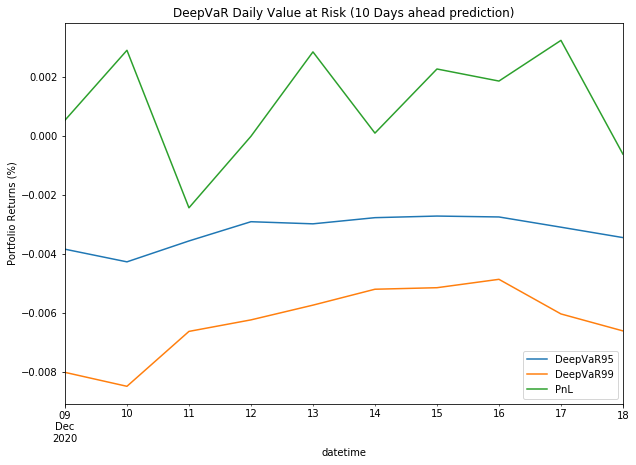

In [13]:
# portfolio weights vector
w = np.ones([4,1]) * 0.25  
# lists to save VaR predictions
var95 = []
var99 = []
for i in range(10):
    var95.append(var_p(forecasts,returns.iloc[-75:], w, i, alpha=95))
    var99.append(var_p(forecasts,returns.iloc[-75:], w, i, alpha=99))

pnl = (returns.iloc[-10:] @ w).values.flatten()

results = pd.DataFrame({'DeepVaR95':var95,'DeepVaR99':var99, 'PnL':pnl}, index=returns.index[-10:])
results.plot(figsize=(10, 7))
plt.title('DeepVaR Daily Value at Risk (10 Days ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show()

### Rolling window prediction

Given the fact that financial markets are a highly dynamic environment, this model could be retrained every day in order to avoid model drift by updating the DeepAR weights based on the latest market movements. 

In the following lines of code we demonstrate this procedure for a small test set of 10-days. Moreover, DeepVaR is compared with two other standard VaR models the Variance Covariance and the Historical Simulation.
  

In [14]:
class VaRCalculation:
    '''Python class to calculate VaR and ES.'''

    def __init__(self, time=1, alpha=95, freq=1):
        self.time = time
        self.alpha = alpha
        self.freq = freq

    def mc(self, x, alpha, n_sims=5000, seed=42):
        '''Monte Carlo VaR'''
        np.random.seed(seed)
        sim_returns = np.random.normal(x.mean(), x.std(), n_sims)
        return np.sqrt(self.time * self.freq) * np.percentile(sim_returns, alpha)

    def vc(self, x, alpha):
        '''Variance-covariance VaR'''
        from scipy import stats
        c = alpha / 100
        return np.sqrt(self.time * self.freq) * (x.std() * stats.norm.ppf(c))

    def hs(self, x, alpha):
        '''Historical Simulation VaR'''
        return np.sqrt(self.time * self.freq) * np.percentile(x, 100 - alpha)

    def es(self, x, alpha):
        '''Expected Shortfall'''
        from scipy import stats
        alpha = 1 - alpha / 100
        return - \
            (alpha ** -1 * stats.norm.pdf(stats.norm.ppf(alpha)) * x.std() * np.sqrt(
                self.time * self.freq) - x.mean()).flatten()[0]

    def predict(self, X, w):
        R = X.corr()
        var = {'vc': 0, 'hs': 0, 'mc': 0, 'es': 0}

        V = np.zeros(len(w))
        for i in range(len(w)):
            V[i] = np.abs(w[i]) * self.vc(X.iloc[:, i], alpha=self.alpha)
        var['vc'] = -np.sqrt(V @ R @ V.T)

        for i in range(len(w)):
            if w[i] < 0:
                V[i] = w[i] * self.hs(X.iloc[:, i], alpha=self.alpha)
            else:
                V[i] = w[i] * self.hs(X.iloc[:, i], alpha=100 - self.alpha)
        var['hs'] = -np.sqrt(V @ R @ V.T)

        for i in range(len(w)):
            if w[i] < 0:
                V[i] = w[i] * self.mc(X.iloc[:, i], alpha=self.alpha)
            else:
                V[i] = w[i] * self.mc(X.iloc[:, i], alpha=100 - self.alpha)
        var['mc'] = -np.sqrt(V @ R @ V.T)

        for i in range(len(w)):
            V[i] = np.abs(w[i]) * self.es(X.iloc[:, i], alpha=self.alpha)
        var['es'] = -np.sqrt(V @ R @ V.T)

        return var

In [15]:
# initialize empty lists to save results
deepvar95 = []
deepvar99 = []
vc95 = []
vc99 = []
hs95 = []
hs99 = []

# iterate over the test set
for i in range(10):
    # train the DeepAR estimator
    estimator = DeepARModel(prediction_length=1, context_length=15, epochs=5).fit(returns.iloc[:-10])
    # predict the distribution of returns for the next day
    predictions_it = estimator.predict(DeepARModel().list_dataset(returns.iloc[:-10+i], train=False), 1000)
    predictions = list(predictions_it)
    # calculate DeepVaR for the next day 
    deepvar95.append(var_p(predictions,returns.iloc[-260+i:-10+i], w, 0, alpha=95))
    deepvar99.append(var_p(predictions,returns.iloc[-260+i:-10+i], w, 0, alpha=99))
    # calculate VaR for the next day with both VC and HS methods
    var99 = VaRCalculation(time=1, alpha=99).predict(returns.iloc[-260+i:-10+i], w)
    var95 = VaRCalculation(time=1, alpha=95).predict(returns.iloc[-260+i:-10+i], w)
    vc95.append(var95['vc'])
    vc99.append(var99['vc'])
    hs95.append(var95['hs'])
    hs99.append(var99['hs'])


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:01<00:00, 28.34it/s, epoch=5/5, avg_epoch_loss=-4.09]


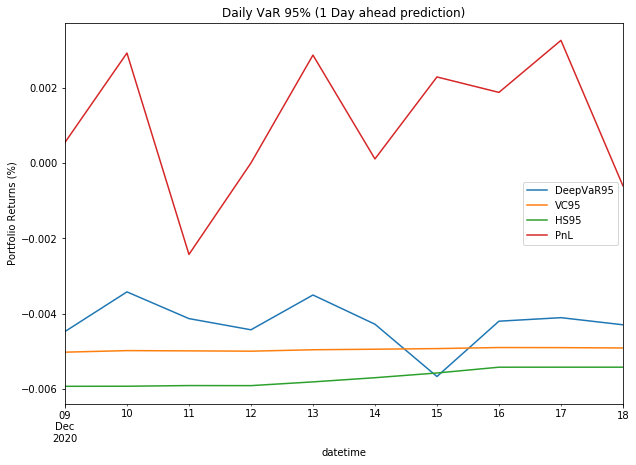

In [16]:
# plot results for 95% VaR
results = pd.DataFrame({'DeepVaR95':deepvar95,'VC95':vc95, 'HS95':hs95, 'PnL':pnl}, index=returns.index[-10:])
results.plot(figsize=(10, 7))
plt.title('Daily VaR 95% (1 Day ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show()

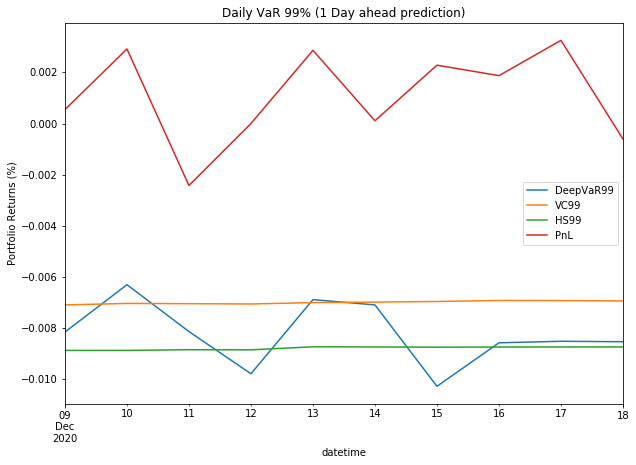

In [17]:
# plot results for 99% VaR
results = pd.DataFrame({'DeepVaR99':deepvar99,'VC99':vc99, 'HS99':hs99, 'PnL':pnl}, index=returns.index[-10:])
results.plot(figsize=(10, 7))
plt.title('Daily VaR 99% (1 Day ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show()